In [1]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import shutil

# pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0
from torchinfo import summary

# Dermatological Conditions Classification
### Run a classification CNN model on different types of dermatological conditions 

In [2]:
os.makedirs('data')
# import shutil
# shutil.rmtree('/kaggle/working/split_data')

## Copy Selected Data to a New Data Folder:

In [3]:
data_path = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/"
dest_path = '/kaggle/working/data/'
data_all = os.listdir(data_path)
print(data_all)


skin_targets = ["3. Atopic Dermatitis - 1.25k", 
                "7. Psoriasis pictures Lichen Planus and related diseases - 2k",
                "1. Eczema 1677"#, 
                # "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k"
               ] 
#0. Warts Molluscum and other Viral Infections - 2103
#9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k

for target in skin_targets:
    target_path = data_path + target
    target_dest_path = dest_path + target
    print(f"\nTarget Name: {target}")
    print(f"Train Len: {len(os.listdir(target_path))}")
    shutil.copytree(target_path, target_dest_path)

['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '4. Basal Cell Carcinoma (BCC) 3323', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '5. Melanocytic Nevi (NV) - 7970', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k', '3. Atopic Dermatitis - 1.25k', '6. Benign Keratosis-like Lesions (BKL) 2624', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '2. Melanoma 15.75k']

Target Name: 3. Atopic Dermatitis - 1.25k
Train Len: 1257

Target Name: 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Train Len: 2055

Target Name: 1. Eczema 1677
Train Len: 1677


In [4]:
!pip install split_folders
import splitfolders

## Change Targets' Names:

In [5]:
path = "/kaggle/working/data/"

dir_list = os.listdir(path) 
print(f"num classes: {len(dir_list)}")

os.rename(path + "1. Eczema 1677", path + "Eczema")
os.rename(path + "7. Psoriasis pictures Lichen Planus and related diseases - 2k", path + "Psoriasis + Lichen Planus")
os.rename(path + "3. Atopic Dermatitis - 1.25k", path + "Atopic Dermatitis")
# # os.rename(path + "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k", path + "Fungal Infections")

skin_targets_renamed = os.listdir(path)
skin_targets_renamed

num classes: 3


['Eczema', 'Psoriasis + Lichen Planus', 'Atopic Dermatitis']

## Split Data to Train, Test and Validation Folders

In [6]:
os.makedirs('split_data')
os.makedirs('split_data/train')
os.makedirs('split_data/val')
os.makedirs('split_data/test')

loc = "/kaggle/working/data/"

splitfolders.ratio(loc, output ="split_data", ratio = (0.80,.1,.1))
# splitfolders.ratio(loc, output ="split_data", ratio = (0.70,.15,.15))

Copying files: 4989 files [00:00, 5472.58 files/s]


In [7]:
path = "/kaggle/working/split_data/train/Atopic Dermatitis"
dir_list = os.listdir(path) 
print(len(dir_list))
path = "/kaggle/working/split_data/val/Atopic Dermatitis"
dir_list = os.listdir(path) 
print(len(dir_list))

1005
125


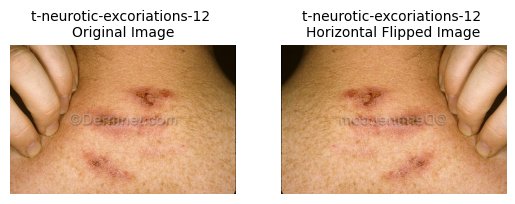

In [8]:
path = "/kaggle/working/split_data/train/"
for target in skin_targets_renamed:
    dir_path = path + target
    dir_list = os.listdir(dir_path) 
    for image_name in dir_list:
        image_path = dir_path + "/" + image_name
        image = Image.open(image_path)
        # transform = transforms.RandomRotation(30)
        # flipped_30_image = transform(image)
        # flipped_30_image.save(f"{image_path.replace('.jpg', '')}_30_flipped.jpg")
        transform = transforms.RandomHorizontalFlip(p=1)
        horizontal_flipped_image = transform(image)
        horizontal_flipped_image.save(f"{image_path.replace('.jpg', '')}_horizontal_flipped.jpg")
        # transform = transforms.ColorJitter(brightness=0.2, contrast=0.2)
        # color_jitter_image = transform(image)
        # color_jitter_image.save(f"{image_path.replace('.jpg', '')}_color_jitter.jpg")

fig, axes = plt.subplots(1, 2)
image_name = "t-neurotic-excoriations-12" #"t-Dyshidrosis-17"
image = Image.open("/kaggle/working/split_data/train/Eczema/" + image_name + ".jpg")
axes[0].imshow(image)
axes[0].set_title(f"{image_name} \nOriginal Image", fontsize = 10)
axes[0].axis('off')
horizontal_flipped_image = Image.open("/kaggle/working/split_data/train/Eczema/" + image_name + "_horizontal_flipped.jpg")
axes[1].imshow(horizontal_flipped_image)
axes[1].set_title(f"{image_name} \nHorizontal Flipped Image", fontsize = 10)
axes[1].axis('off')
plt.show()

## Create pytorch dataset

In [10]:
train_path = "/kaggle/working/split_data/train/"
val_path = "/kaggle/working/split_data/val/"
test_path = "/kaggle/working/split_data/test/"

# implement pytorch dataset:
class SkinDataset(Dataset):

    def __init__(self, mode = 'train', transform = transforms.ToTensor()):
        self.mode = mode 
        self.target_dict = {}
        self.skin_targets = skin_targets_renamed
        img_paths, img_targets = self.get_data()
        self.img_paths = img_paths
        self.img_targets = img_targets
        self.transform = transform
        
    def __len__(self): # == len(dataset)
        return len(self.img_paths)
        
    def __getitem__(self, index): # == dataset[index] 
        img = Image.open(self.img_paths[index])
        # img = img.filter(ImageFilter.GaussianBlur(radius=2)) #reduce noises
        img = self.transform(img)
        return {"img": img, "target": self.img_targets[index]}

    def get_data(self):
        dir_path = train_path if self.mode == 'train' else val_path if self.mode == 'val' else test_path
        image_paths = []
        image_target = []
        for i in range(len(skin_targets)):
            target_path = dir_path + self.skin_targets[i]
            self.target_dict[i] = self.skin_targets[i]
            print(f"target_path: {target_path}")
            for path in os.listdir(target_path):
                img_path = target_path + "/" + path
                image_paths.append(img_path)
                image_target.append(i) # target index
        return image_paths, image_target
        

train_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),   # Flip images randomly
    transforms.RandomRotation(degrees=45),   
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),  # More aggressive cropping
    transforms.RandomAffine(degrees=0, shear=20),  # Increase shear for perspective shifts
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Stronger distortions
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),  # Apply perspective transformation
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # Blur to prevent memorization
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Standard normalization
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))  # Cutout to hide parts of the image
])

# train_transform = transforms.Compose([
#     transforms.RandomRotation(degrees=60),  # Increased rotation range
#     transforms.RandomResizedCrop(224, scale=(0.4, 1.0)),  # More aggressive crop
#     transforms.RandomAffine(degrees=30, shear=30),  # Increased shear and rotation
#     transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.2),  # Stronger color distortions
#     transforms.RandomPerspective(distortion_scale=0.5, p=0.7),  # Stronger perspective distortion
#     transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 3.0)),  # Stronger blur
#     transforms.ToTensor(),
#     transforms.RandomErasing(p=0.5, scale=(0.01, 0.25), ratio=(0.2, 4.0)),  # Stronger Cutout
# ])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No augmentation for validation
    transforms.ToTensor()#,
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train = SkinDataset(mode = 'train', transform = train_transform)
print(f"train len: {len(train)}") 

test = SkinDataset(mode = 'val', transform = val_transform)
print(f"test len: {len(test)}") 

val = SkinDataset(mode = 'test', transform = val_transform)
print(f"test len: {len(test)}") 

target_path: /kaggle/working/split_data/train/Eczema
target_path: /kaggle/working/split_data/train/Psoriasis + Lichen Planus
target_path: /kaggle/working/split_data/train/Atopic Dermatitis
train len: 7980
target_path: /kaggle/working/split_data/val/Eczema
target_path: /kaggle/working/split_data/val/Psoriasis + Lichen Planus
target_path: /kaggle/working/split_data/val/Atopic Dermatitis
test len: 497
target_path: /kaggle/working/split_data/test/Eczema
target_path: /kaggle/working/split_data/test/Psoriasis + Lichen Planus
target_path: /kaggle/working/split_data/test/Atopic Dermatitis
test len: 497


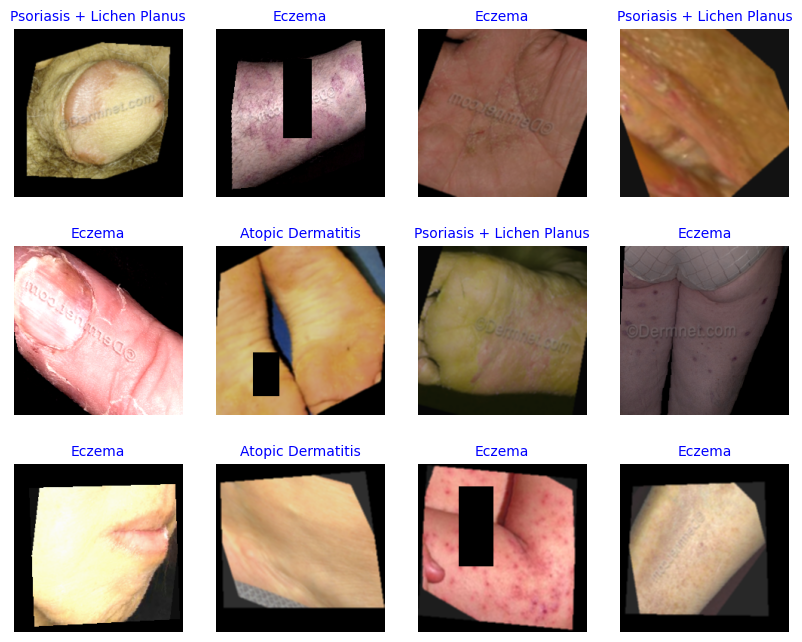

In [11]:
example_list = [train[i] for i in random.sample(range(len(train)), k=12)]

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for ax, img_item in zip(axes.ravel(), example_list):
    img = transforms.functional.to_pil_image(img_item['img'])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(train.target_dict[img_item['target']], fontsize=10, color="blue")

plt.show()

In [11]:
# Set the device
c_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = c_device.type == 'cuda'
print(f"device: {c_device}")

batch_s = 64

# Create dataloaders for training and test sets
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_s, shuffle=True, pin_memory=pin_memory, num_workers=3)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_s, pin_memory=pin_memory, num_workers=3)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_s, pin_memory=pin_memory, num_workers=3)

batch = next(iter(train_loader))
print(batch['img'].shape)
print(batch['target'].shape)

device: cuda
torch.Size([64, 3, 224, 224])
torch.Size([64])


# Torch lightning

In [12]:
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix
from sklearn.metrics import classification_report
import seaborn as sns


NUM_CLASSES = 3
from torchvision.models import efficientnet_b3 # better then b0 or b2
efficientnet_model = efficientnet_b3(weights="IMAGENET1K_V1")
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(efficientnet_model.classifier[1].in_features, NUM_CLASSES)  # Adjust output layer
)

# efficientnet_model = efficientnet_b0(weights="IMAGENET1K_V1")  # Load pre-trained weights
# efficientnet_model.classifier = nn.Sequential(
#     nn.Dropout(0.3),
#     nn.Linear(efficientnet_model.classifier[1].in_features, NUM_CLASSES)  # Adjust output layer
# )

class MyLitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.model = efficientnet_model
        self.train_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.loss_fn = nn.CrossEntropyLoss() 
        self.conf_matrix = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)
        self.all_preds = []
        self.all_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x = batch['img']
        y = batch['target']
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        acc = self.train_accuracy(logits, y)
        self.log("train_accuracy", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch['img']
        y = batch['target']
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("val_loss", loss)
        acc = self.val_accuracy(logits, y)
        self.log("val_accuracy", acc)

    def configure_optimizers(self):
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # better loss - mom global minima, lr=0.0001
        # optimizer = optim.Adam(self.parameters(), lr=0.01) #, weight_decay=1e-4
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.2, min_lr=1e-6, verbose=True)
        return {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "monitor": "val_loss",
           },
        }

    def test_step(self, batch, batch_idx):
        x = batch['img']
        y = batch['target']
        y_hat = self(x).argmax(dim=1)  # Predicted class
        self.conf_matrix.update(y_hat, y)  # Update confusion matrix
        self.all_preds.append(y_hat)  # Collect predictions
        self.all_labels.append(y)  # Collect true labels
        return {"preds": y_hat, "targets": y}

    def on_test_epoch_end(self):
        # print classification report 
        y_names = test.target_dict
        preds = torch.cat(self.all_preds, dim=0).cpu().numpy()
        labels = torch.cat(self.all_labels, dim=0).cpu().numpy()
        report = classification_report(labels, preds, target_names=[test.target_dict[0], test.target_dict[1], test.target_dict[2]])  # Adjust for your classes
        print(report)
        self.all_preds.clear()
        self.all_labels.clear()
        # Plot confusion matrix
        cm = self.conf_matrix.compute().cpu().numpy()
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 207MB/s]


to continue 

In [13]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger


model = MyLitModel()
logger = CSVLogger(save_dir="logs/", name="csv_logs")

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    devices="auto",
    logger=logger, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=20)]
)

trainer.fit(model, train_loader, val_loader)

# SGD 0.01: 0.9 vs 0.75, loss: 0.2 vs 0.6, patience = 10
# SGD 0.001: 0.82 vs 0.75, loss: 0.4 vs 0.65, patience = 7
# 2 augmatation + SGD 0.01 : 0.84 vs 0.75, loss: 0.3 vs 0.7, patience = 7
# 2 augmentation, without erase + SGD 0.001: 0.9 vs 0.76, loss: 0.26 vs 0.64, patience = 7
# 2 augmentation, with erase + adam 0.01: 0.7 vs 0.6, loss: 0.7 vs 0.8, patience = 10
# 2 augmentation, with erase + SGD 0.01: 0.9 vs 0.77, loss: 0.17 vs 0.8, patience = 10
# 2 augmentation, with erase + SGD 0.001, Dropout(0.3) : 0.85 vs 0.75, loss: 0.3 vs 0.6 patience = 10 - best till now
# same with SGD 0.0001, 50 epochs- almost same for train and test: 0.620265	vs	0.609562	0.872089	vs 0.895524
# same with SGD 0.0001, 100 epochs- almost same for train and test: 0.698864 vs 0.683267, 0.722820 vs	0.751789
# same with SGD 0.0001, 108/200 epochs- almost same for train and test, but low results
# resnet50 model: not good.
# b3 - better 0.01  patience=10- test acc of 0.77 and loss of 0.68
# b3  0.01  patience=15 - test acc of 0.8 and loss of 0.7
# 0.1 loss very high, adam less good
# 45 rott - patience=15,lr=0.01,  better 0.862689	0.315674	0.784861	0.635052

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [14]:
 os.listdir("/kaggle/working/logs/csv_logs/") 

['version_0']

In [15]:
import pandas as pd
log_path = "logs/csv_logs/version_0/metrics.csv"
df = pd.read_csv(log_path, sep=',')
df = df.groupby('epoch').mean()  # merge the train and valid rows
df['epoch'] = df.index  # because "Epoch" gets turned into the index
df.index.name = ''  # to remove the name "Epoch" from the index
df

,step,train_accuracy,train_loss,val_accuracy,val_loss,epoch
,,,,,,
0,90.666667,0.328125,1.077922,0.452191,1.992976,0
1,211.500000,0.444602,1.017304,0.476096,1.307124,1
2,340.666667,0.601562,0.916342,0.505976,1.053244,2
3,461.500000,0.546875,0.987185,0.525896,0.950576,3
4,590.666667,0.632812,0.852906,0.559761,0.912585,4
...,...,...,...,...,...,...
78,9840.666667,0.843750,0.433833,0.754980,0.583551,78
79,9961.500000,0.829072,0.424666,0.762948,0.584953,79
80,10090.666667,0.835938,0.435323,0.760956,0.581891,80


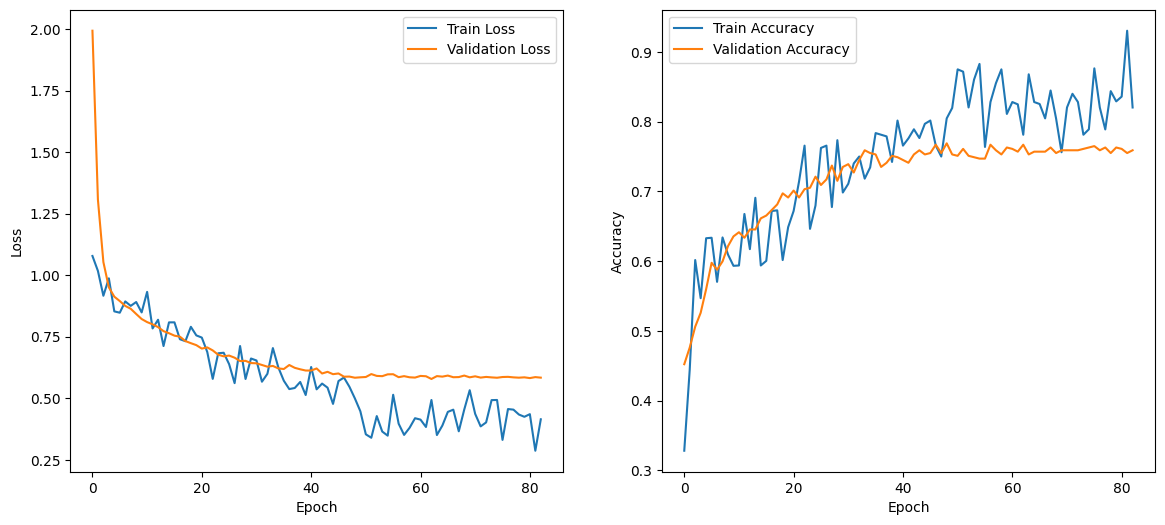

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(df["epoch"], df["train_loss"], label="Train Loss")
axes[0].plot(df["epoch"], df["val_loss"], label="Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(df["epoch"], df["train_accuracy"], label="Train Accuracy")
axes[1].plot(df["epoch"], df["val_accuracy"], label="Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()


plt.show()

{0: 'Eczema', 1: 'Psoriasis + Lichen Planus', 2: 'Atopic Dermatitis'}


Testing: |          | 0/? [00:00<?, ?it/s]

                           precision    recall  f1-score   support

                   Eczema       0.79      0.72      0.75       167
Psoriasis + Lichen Planus       0.75      0.81      0.78       205
        Atopic Dermatitis       0.70      0.70      0.70       125

                 accuracy                           0.75       497
                macro avg       0.75      0.74      0.74       497
             weighted avg       0.75      0.75      0.75       497



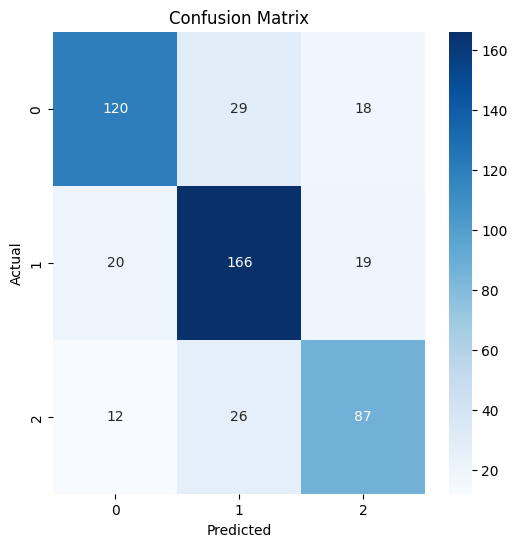

[{}]

In [17]:
print(test.target_dict)
trainer.test(model, dataloaders=test_loader)